In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import re
import helper 
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.datasets import make_classification

## Data Modeling Workflow
The following workflow will be applied in building the data model:
1.  Idetify tests at assessment and weeks 0 - 4 for treatment<br>
2.  Identify surveys at assessment and weeks 0, 4 for treatment
3.  Extract Other Numeric Baseline Predictors, including:
    - attendence
    - medication dose
    - clinical opiate withdrawal scale - score of 1 - 13, lower score shows lower withdrawal symptoms
4.  Extract Catagorical Baseline Predictors, including:
    - Demographics
    - Substance Use Diagnosis
    - Mental and Pysical Health History
    - Physical Exam

## Load Data

In [2]:
# read csv file
data = pd.read_csv('../data/merged_data.csv')

print('Shape of dataframe prior to modeling:', data.shape)
display(data.head())

Shape of dataframe prior to modeling: (1917, 419)


,patdeid,rsa_week_0,rsa_week_1,rsa_week_2,rsa_week_3,rsa_week_4,rsa_week_5,rsa_week_6,rsa_week_7,rsa_week_8,...,pex_neurological,pex_gen_appearance,pex_ears_nose_throat,pex_head_neck,pex_cardio,pex_skin,medication,weeks_comp,cows_predose,cows_postdose
0,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,normal,normal,normal,normal,normal,normal,2.0,27,11.0,6.0
1,2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,normal,abnormal,abnormal,normal,normal,abnormal,2.0,27,8.0,1.0
2,3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,normal,normal,normal,normal,normal,abnormal,1.0,27,8.0,5.0
3,4,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,...,normal,normal,normal,normal,normal,normal,2.0,27,11.0,9.0
4,5,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,not_present,not_present,not_present,not_present,not_present,not_present,2.0,1,0.0,0.0


## Review Tests

In [3]:
test_names = [
 'Propoxyphene',
 #'Amphetamines',
 #'Cannabinoids',
 #'Benzodiazepines',
 'MMethadone',
 'Oxycodone',
 #'Cocaine',
 #'Methamphetamine',
 'Opiate300'
 ]

# define prefix parameter and call helper function to build the dataset
prefix = 'test_'
tests = helper.feature_selection(data, prefix, test_names)

Shape of tests DataFrame: (1917, 20)


,test_Propoxyphene_0,test_MMethadone_0,test_Oxycodone_0,test_Opiate300_0,test_Propoxyphene_1,test_MMethadone_1,test_Oxycodone_1,test_Opiate300_1,test_Propoxyphene_2,test_MMethadone_2,test_Oxycodone_2,test_Opiate300_2,test_Propoxyphene_3,test_MMethadone_3,test_Oxycodone_3,test_Opiate300_3,test_Propoxyphene_4,test_MMethadone_4,test_Oxycodone_4,test_Opiate300_4
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0
4,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1912,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1913,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1914,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1915,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


## Review Surveys


In [4]:
# comment out the drugs you don't want to include
survey_names = [
#'cannabis',
#'cocaine',
#'alcohol',
'oxycodone',
'mmethadone',
#'amphetamine',
#'methamphetamine',
'opiates',
#'benzodiazepines'
]

# call helper function to build  the dataset
prefix = 'survey_'
surveys = helper.feature_selection(data, prefix, survey_names)

Shape of tests DataFrame: (1917, 6)


,survey_oxycodone_0,survey_mmethadone_0,survey_opiates_0,survey_oxycodone_4,survey_mmethadone_4,survey_opiates_4
0,0.0,0.0,30.0,0.0,0.0,0.0
1,0.0,0.0,30.0,0.0,0.0,5.0
2,0.0,0.0,30.0,0.0,0.0,9.0
3,1.0,0.0,30.0,0.0,0.0,6.0
4,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...
1912,0.0,0.0,30.0,0.0,0.0,0.0
1913,0.0,4.0,30.0,0.0,0.0,3.0
1914,0.0,0.0,0.0,0.0,0.0,0.0
1915,0.0,0.0,0.0,0.0,0.0,0.0


## Create Dataframe for Baseline Numeric Predictors

In [5]:
# attendance data, included up to week 4
rsa = data[[col for col in data.columns if 'rsa' in col]].iloc[:, :5]

# medication data, included up to week 4
meds = data[[col for col in data.columns if 'med' in col]].iloc[:, :10]

# clinical opiate withdrawal scale -  included for baseline and week 0
cows = data[[col for col in data.columns if 'cows' in col]]

# create dataframe with numeric features
num_df = pd.concat([tests, surveys, rsa, meds, cows], axis=1)

print('Shape of numeric dataframe',num_df.shape)
display(num_df)

Shape of numeric dataframe (1917, 43)


,test_Propoxyphene_0,test_MMethadone_0,test_Oxycodone_0,test_Opiate300_0,test_Propoxyphene_1,test_MMethadone_1,test_Oxycodone_1,test_Opiate300_1,test_Propoxyphene_2,test_MMethadone_2,...,meds_methadone_1,meds_buprenorphine_1,meds_methadone_2,meds_buprenorphine_2,meds_methadone_3,meds_buprenorphine_3,meds_methadone_4,meds_buprenorphine_4,cows_predose,cows_postdose
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,160.0,0.0,320.0,0.0,192.0,0.0,384.0,11.0,6.0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,48.0,0.0,48.0,0.0,60.0,0.0,48.0,8.0,1.0
2,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,...,170.0,0.0,310.0,0.0,420.0,0.0,360.0,0.0,8.0,5.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,152.0,0.0,192.0,0.0,160.0,0.0,64.0,11.0,9.0
4,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,152.0,0.0,192.0,0.0,160.0,0.0,64.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1912,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,270.0,0.0,250.0,0.0,300.0,0.0,360.0,0.0,0.0,0.0
1913,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,160.0,0.0,112.0,0.0,112.0,0.0,112.0,17.0,12.0
1914,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,160.0,0.0,112.0,0.0,112.0,0.0,112.0,0.0,0.0
1915,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,160.0,0.0,112.0,0.0,112.0,0.0,112.0,0.0,0.0


## Review Categorical Data

In [6]:
# demographic data
#dem = data[[col for col in data.columns if col.startswith('dem_')]]
#dem = pd.get_dummies(dem, dtype=int)
# create df for diagnosis
#dsm = data[[col for col in data.columns if col.startswith('dsm_')]]
#dsm = pd.get_dummies(dsm, dtype=int)
# create df for medical history
mdh = data[[col for col in data.columns if col.startswith('mdh_')]]
#mdh = pd.get_dummies(mdh, dtype=int)

# create df for physical exam
#pex = data[[col for col in data.columns if col.startswith('pex_')]]
#pex = pd.get_dummies(pex, dtype=int)

# concat cat features into cat_df
cat_df = pd.concat([mdh], axis=1)

print('shape of the categorical df:',cat_df.shape)
display(cat_df)

shape of the categorical df: (1917, 18)


,mdh_liver_problems,mdh_kidney_problems,mdh_alc_withdrawal,mdh_schizophrenia,mdh_major_depressive_disorder,mdh_bipolar_disorder,mdh_anxiety_disorder,mdh_sig_neurological_damage,mdh_allergies,mdh_gi_problems,mdh_thyroid_problems,mdh_heart_condition,mdh_asthma,mdh_hypertension,mdh_skin_disease,mdh_head_injury,mdh_opi_withdrawal,mdh_epilepsy
0,yes_history,no_history,no_history,no_history,yes_history,no_history,yes_history,no_history,no_history,yes_history,no_history,no_history,no_history,no_history,no_history,no_history,yes_history,no_history
1,no_history,no_history,no_history,no_history,no_history,no_history,no_history,no_history,no_history,no_history,no_history,no_history,no_history,no_history,yes_history,no_history,no_history,no_history
2,no_history,no_history,no_history,no_history,no_history,no_history,no_history,no_history,no_history,no_history,no_history,no_history,no_history,no_history,yes_history,no_history,yes_history,no_history
3,no_history,no_history,no_history,no_history,no_history,no_history,yes_history,no_history,no_history,no_history,no_history,no_history,no_history,no_history,no_history,no_history,yes_history,no_history
4,not_evaluated,not_evaluated,not_evaluated,not_evaluated,not_evaluated,not_evaluated,not_evaluated,not_evaluated,not_evaluated,not_evaluated,not_evaluated,not_evaluated,not_evaluated,not_evaluated,not_evaluated,not_evaluated,not_evaluated,not_evaluated
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1912,yes_history,no_history,no_history,no_history,no_history,no_history,yes_history,no_history,no_history,no_history,no_history,no_history,no_history,no_history,no_history,yes_history,yes_history,no_history
1913,no_history,no_history,yes_history,no_history,no_history,no_history,no_history,no_history,yes_history,no_history,no_history,no_history,yes_history,no_history,yes_history,no_history,no_history,no_history
1914,no_history,yes_history,no_history,no_history,yes_history,no_history,yes_history,no_history,yes_history,no_history,no_history,yes_history,no_history,no_history,no_history,no_history,yes_history,no_history
1915,yes_history,no_history,no_history,no_history,no_history,no_history,no_history,yes_history,no_history,no_history,no_history,no_history,no_history,no_history,no_history,yes_history,yes_history,no_history


### We found some noisy data in this dataset
There were two different imputations applied to dsm columns<br>
Combine 'not_present' and 'not_evaluated' to 'not_evaluated'<br>
There is a 0 value in `dem_gender` in 3 rows, we will delete them<br>

In [7]:
# replace values labeled 'not_present', with 'not_evaluated'
#cat_df = cat_df.replace('not_present', 'not_evaluated')

# remove rows with 0 values
#cat_df.loc[cat_df.dem_gender!='0']

#print(cat_df.shape)
#display(cat_df)

In [8]:
# one hot encode cat_df
cat_df = pd.get_dummies(cat_df, drop_first=True, dtype=float)

print(cat_df.shape)
display(cat_df)

(1917, 36)


,mdh_liver_problems_not_evaluated,mdh_liver_problems_yes_history,mdh_kidney_problems_not_evaluated,mdh_kidney_problems_yes_history,mdh_alc_withdrawal_not_evaluated,mdh_alc_withdrawal_yes_history,mdh_schizophrenia_not_evaluated,mdh_schizophrenia_yes_history,mdh_major_depressive_disorder_not_evaluated,mdh_major_depressive_disorder_yes_history,...,mdh_hypertension_not_evaluated,mdh_hypertension_yes_history,mdh_skin_disease_not_evaluated,mdh_skin_disease_yes_history,mdh_head_injury_not_evaluated,mdh_head_injury_yes_history,mdh_opi_withdrawal_not_evaluated,mdh_opi_withdrawal_yes_history,mdh_epilepsy_not_evaluated,mdh_epilepsy_yes_history
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1912,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1913,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1914,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1915,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0


## Assign Target Variable and Combine

In [9]:
# assigne dropout variable
dropout = data['dropout']

# merge
new_data = pd.concat([num_df, cat_df, dropout], axis=1)

print('Shape of new datframe:',new_data.shape)
display(new_data)


Shape of new datframe: (1917, 80)


,test_Propoxyphene_0,test_MMethadone_0,test_Oxycodone_0,test_Opiate300_0,test_Propoxyphene_1,test_MMethadone_1,test_Oxycodone_1,test_Opiate300_1,test_Propoxyphene_2,test_MMethadone_2,...,mdh_hypertension_yes_history,mdh_skin_disease_not_evaluated,mdh_skin_disease_yes_history,mdh_head_injury_not_evaluated,mdh_head_injury_yes_history,mdh_opi_withdrawal_not_evaluated,mdh_opi_withdrawal_yes_history,mdh_epilepsy_not_evaluated,mdh_epilepsy_yes_history,dropout
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
4,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1912,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
1913,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1914,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1915,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0


## Save to CSV for ML Pipelines

In [10]:
# save to csv
new_data.to_csv('../data/classification_df.csv', index=False)

## Classification Workflow

In [11]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
import numpy as np


# create train, test and eval set
from fast_ml.model_development import train_valid_test_split
train = 0.7
test = 0.2
validation = 0.1
X_train, y_train, X_val, y_val, X_test, y_test = train_valid_test_split(new_data,
                      target='dropout',
                      train_size=train,                        
                      test_size=test,
                      valid_size=validation)

# print shape of all data sets
print('Shape of X_train:', X_train.shape)
print('Shape of X_val:', X_val.shape)
print('Shape of X_test:', X_test.shape)

Shape of X_train: (1341, 79)
Shape of X_val: (192, 79)
Shape of X_test: (384, 79)


In [12]:
gbm_param_grid = {
	'learning_rate': [0.01, 0.1, 0.5, 0.9],
	'n_estimators': [200, 300, 400],
    'max_depth': [3, 6, 9],
	'objective': ['binary:logistic']  # Specify binary logistic objective
}

gbm = xgb.XGBClassifier(use_label_encoder=False)  # XGBClassifier for classification tasks
grid_auc = GridSearchCV(estimator=gbm, 
                        param_grid=gbm_param_grid, 
                        scoring='roc_auc', 
                        cv=5, 
                        verbose=1, 
                        return_train_score=True,
                        n_jobs=-1)  # Use ROC AUC as the scoring metric

grid_auc.fit(X_train, y_train)
print("Best parameters found: ", grid_auc.best_params_)
print("Highest ROC AUC found: ", grid_auc.best_score_)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters found:  {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 400, 'objective': 'binary:logistic'}
Highest ROC AUC found:  0.897614344752985


In [13]:
# refit the model with the best params
best_params = grid_auc.best_params_

# best model
best_gbm = xgb.XGBClassifier(**best_params)

# fit the model
best_gbm.fit(X_train, y_train, eval_set=[(X_train,y_train),(X_val, y_val)], eval_metric=['auc','error'], verbose=False)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

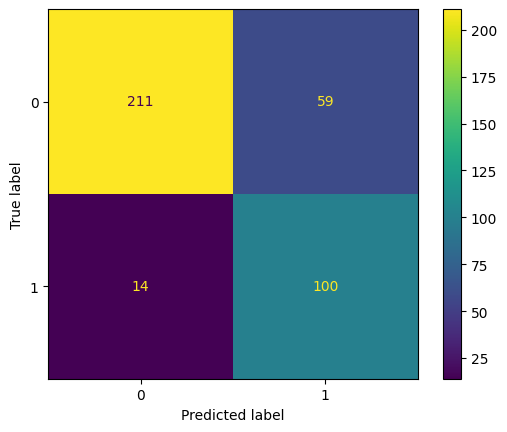

In [14]:
# plot the confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
y_pred = best_gbm.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_gbm.classes_)
disp.plot();

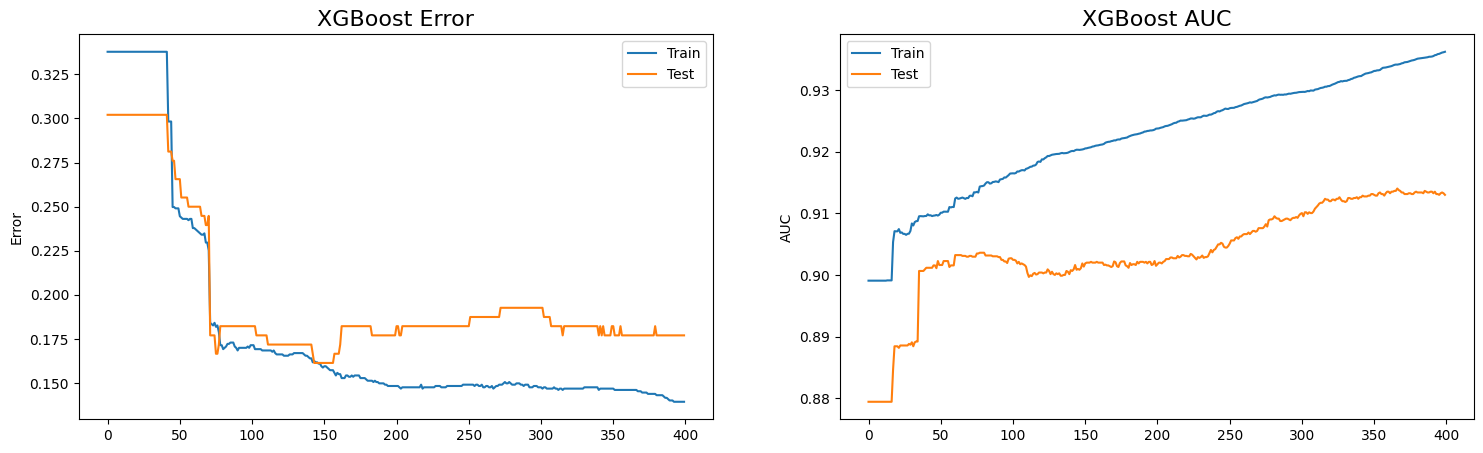

In [15]:
# retrieve performance metrics
results = best_gbm.evals_result()
epochs = len(results['validation_0']['auc'])
x_axis = range(0, epochs)

# plot log loss and classification error 
fig, axs = plt.subplots(ncols=2, figsize=(18, 5))

# plot log loss
axs[0].plot(x_axis, results['validation_0']['error'], label='Train')
axs[0].plot(x_axis, results['validation_1']['error'], label='Test')
axs[0].legend()
axs[0].set_ylabel('Error')
axs[0].set_title('XGBoost Error', fontsize=16)

# plot classification error
axs[1].plot(x_axis, results['validation_0']['auc'], label='Train')
axs[1].plot(x_axis, results['validation_1']['auc'], label='Test')
axs[1].legend()
axs[1].set_ylabel('AUC')
axs[1].set_title('XGBoost AUC', fontsize=16)

plt.show()


In [16]:
# make predictions to evaluate the model
y_pred_train = best_gbm.predict(X_train)
y_pred_val = best_gbm.predict(X_val)
y_pred_test = best_gbm.predict(X_test)

### Create DF with Train, Val and Test metrics

In [17]:
from sklearn.metrics import classification_report

# Assuming you have your predictions as y_pred_train, y_pred_val, y_pred_test
# and the true labels as y_train, y_val, y_test

# Generate classification reports
report_train = classification_report(y_train, y_pred_train, output_dict=True)
report_val = classification_report(y_val, y_pred_val, output_dict=True)
report_test = classification_report(y_test, y_pred_test, output_dict=True)

# Create DataFrames from reports
df_train = pd.DataFrame(report_train).transpose()
df_val = pd.DataFrame(report_val).transpose()
df_test = pd.DataFrame(report_test).transpose()

# Add a column to distinguish between datasets
df_train['dataset'] = 'Training'
df_val['dataset'] = 'Validation'
df_test['dataset'] = 'Test'

# Concatenate all three DataFrames
df_all = pd.concat([df_train, df_val, df_test], axis=0).reset_index()

# Rename 'index' column to something more descriptive, like 'metric'
df_all.rename(columns={'index': 'metric'}, inplace=True)

# subset columns
df_all = df_all[['metric','precision','dataset']]

# pivot the dataframe
df_all = df_all.pivot(index='dataset', columns='metric', values='precision').reset_index()

# reorder rows, 1, 2, 0
df_all = df_all.reindex([1,2,0])

df_all

metric,dataset,0.0,1.0,accuracy,macro avg,weighted avg
1,Training,0.965471,0.726190,0.860552,0.845831,0.884641
2,Validation,0.903226,0.676471,0.822917,0.789848,0.834727
0,Test,0.937778,0.628931,0.809896,0.783354,0.846089


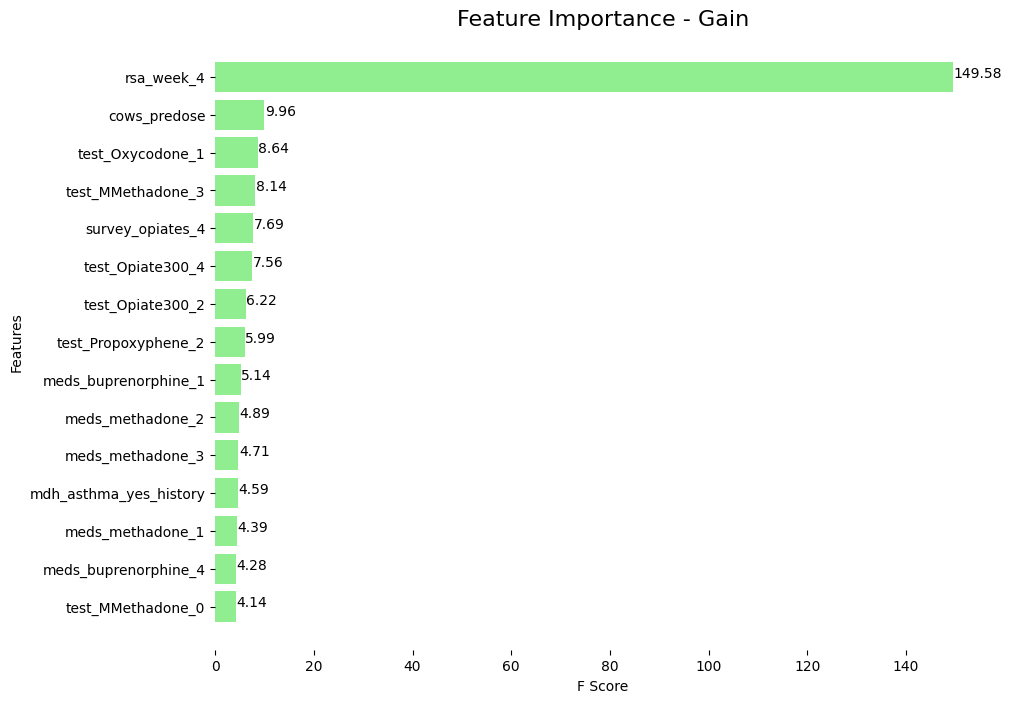

In [18]:
import matplotlib.pyplot as plt
import xgboost as xgb

# Assuming grid_auc.best_estimator_ is your trained XGBoost model
model = grid_auc.best_estimator_

metric='gain'
plot = metric.capitalize().replace('_g', ' G')

# Get feature importances and round them
importances = model.get_booster().get_score(importance_type=metric)
importances_rounded = {k: round(v, 2) for k, v in importances.items()}

# Sort features by importance
sorted_importances = sorted(importances_rounded.items(), key=lambda x: x[1], reverse=True)[:15]

# Separate keys and values for plotting
features, scores = zip(*sorted_importances)

# Plot
plt.figure(figsize=(10, 8))
plt.barh(range(len(scores)), scores, color='lightgreen')
plt.yticks(range(len(scores)), features)
plt.xlabel('F Score')
plt.ylabel('Features')
# annotate the values over the bars
for i, v in enumerate(scores):
    plt.text(v + 0.1, i - 0.1, str(v), color='black', va='center')
plt.title(f'Feature Importance - {plot}', fontsize=16)
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature on top
# remove borders
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.show()

## Create a DF with all the trees

In [19]:
# Assuming `grid_auc` is your trained GridSearchCV object with an XGBClassifier
best_model = grid_auc.best_estimator_

# Extract the Booster
booster = best_model.get_booster()

# Convert the trees to a DataFrame
trees_df = booster.trees_to_dataframe().iloc[:, :10]

trees_df = trees_df.sort_values(by='Gain', ascending=False)

In [47]:
trees_df

,Tree,Node,ID,Feature,Split,Yes,No,Missing,Gain,Cover
0,0,0,0-0,rsa_week_4,1.0,0-1,0-2,0-2,587.037292,302.307983
15,1,0,1-0,rsa_week_4,1.0,1-1,1-2,1-2,575.846680,302.271942
30,2,0,2-0,rsa_week_4,1.0,2-1,2-2,2-2,564.940186,302.208160
45,3,0,3-0,rsa_week_4,1.0,3-1,3-2,3-2,554.307617,302.117554
60,4,0,4-0,rsa_week_4,1.0,4-1,4-2,4-2,543.939575,302.000854
...,...,...,...,...,...,...,...,...,...,...
67,4,7,4-7,Leaf,NaN,NaN,NaN,NaN,-0.014739,133.973175
52,3,7,3-7,Leaf,NaN,NaN,NaN,NaN,-0.014813,134.643341
37,2,7,2-7,Leaf,NaN,NaN,NaN,NaN,-0.014888,135.306976
22,1,7,1-7,Leaf,NaN,NaN,NaN,NaN,-0.014965,135.963821


In [50]:
trees_df.loc[trees_df['Feature'] == 'test_Oxycodone_1']

,Tree,Node,ID,Feature,Split,Yes,No,Missing,Gain,Cover
3084,206,0,206-0,test_Oxycodone_1,1.0,206-1,206-2,206-2,28.386793,193.225555
3112,208,0,208-0,test_Oxycodone_1,1.0,208-1,208-2,208-2,27.693527,192.578873
3140,210,0,210-0,test_Oxycodone_1,1.0,210-1,210-2,210-2,27.009806,191.936676
3168,212,0,212-0,test_Oxycodone_1,1.0,212-1,212-2,212-2,26.341186,191.306229
3196,214,0,214-0,test_Oxycodone_1,1.0,214-1,214-2,214-2,25.701757,190.677597
...,...,...,...,...,...,...,...,...,...,...
4391,307,2,307-2,test_Oxycodone_1,1.0,307-5,307-6,307-6,3.223624,160.884445
4437,311,2,311-2,test_Oxycodone_1,1.0,311-5,311-6,311-6,3.137887,160.587921
4472,314,2,314-2,test_Oxycodone_1,1.0,314-5,314-6,314-6,3.071003,160.374908
4507,317,2,317-2,test_Oxycodone_1,1.0,317-5,317-6,317-6,2.998940,160.172348


## Plot a Specific Estimator


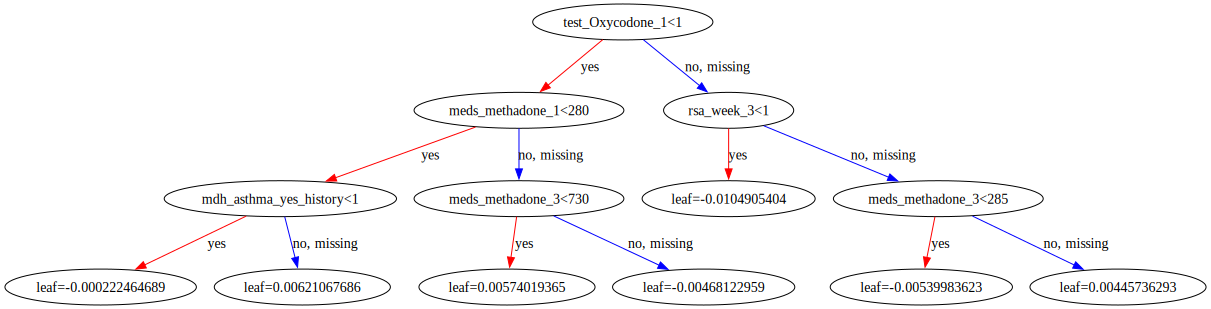

In [51]:
# plot tree with to_graphviz() sideways
graph = xgb.to_graphviz(booster, num_trees=206)
graph

## Analyze Test Set with Predictions

In [32]:
# Assuming `model` is your trained model and `X_test`, `y_test` are your test datasets
predictions = best_gbm.predict(X_test)

# Convert X_test to a DataFrame if it's not already
X_test_df = pd.DataFrame(X_test, columns=X_test.columns)

# Add predictions and actual labels to the DataFrame
X_test_df['Prediction'] = predictions
X_test_df['Actual'] = y_test

# Function to classify each prediction
def classify_prediction(row):
	if row['Prediction'] == row['Actual']:
		return 'TP' if row['Prediction'] == 1 else 'TN'
	else:
		return 'FP' if row['Prediction'] == 1 else 'FN'

# Apply the function to classify predictions
X_test_df['Classification'] = X_test_df.apply(classify_prediction, axis=1)

# Now X_test_df includes the test data, predictions, actual labels, and classification (TP, TN, FP, FN)
test_set = X_test_df

### Analyzing `test_Oxcycone_1` as a predictor
- We will look at the true positive rate for those testing positive for oxycodone at week 1
- The prediction will correctly predict dropout 46% of the time

if we look at the test set, we can see patients that test negative for Oxycodone week 1
they are classified as true positive for dropout 46% of the time and true negative 21% of the time


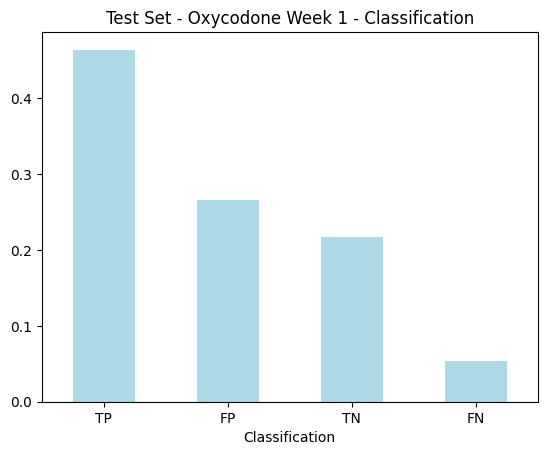

In [61]:
print('if we look at the test set, we can see patients that test negative for Oxycodone week 1')
print('they are classified as true positive for dropout 46% of the time and true negative 21% of the time')
test_set.loc[test_set['test_Oxycodone_1']==0]['Classification'].value_counts(normalize=True).plot(kind='bar', color='lightblue')
plt.title('Test Set - Oxycodone Week 1 - Classification')
plt.xticks(rotation=0)
plt.show()

## Analyze True Positives for Droput
- 207 patients tested negative for oxycodone week 1
- 46% percent of patients droped out



In [76]:
test_set[test_set['test_Oxycodone_1']==0]

,test_Propoxyphene_0,test_MMethadone_0,test_Oxycodone_0,test_Opiate300_0,test_Propoxyphene_1,test_MMethadone_1,test_Oxycodone_1,test_Opiate300_1,test_Propoxyphene_2,test_MMethadone_2,...,mdh_skin_disease_yes_history,mdh_head_injury_not_evaluated,mdh_head_injury_yes_history,mdh_opi_withdrawal_not_evaluated,mdh_opi_withdrawal_yes_history,mdh_epilepsy_not_evaluated,mdh_epilepsy_yes_history,Prediction,Actual,Classification
255,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1,1.0,TP
634,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1,1.0,TP
1765,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1,0.0,FP
676,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1,0.0,FP
585,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0,1.0,FN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1,0.0,FP
1761,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1,0.0,FP
1762,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1,1.0,TP
811,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1,1.0,TP


In [90]:

test_set.loc[
    (test_set['test_Oxycodone_1']==0)& 
    (test_set['Classification']=='TP')
             ][[col for col in test_set.columns if 'mdh_' in col]].sum().sort_values(ascending=False).to_frame('count')[:10]

,count
mdh_opi_withdrawal_yes_history,83.0
mdh_liver_problems_yes_history,34.0
mdh_head_injury_yes_history,32.0
mdh_anxiety_disorder_yes_history,32.0
mdh_allergies_yes_history,30.0
mdh_major_depressive_disorder_yes_history,27.0
mdh_skin_disease_yes_history,22.0
mdh_gi_problems_yes_history,19.0
mdh_hypertension_yes_history,16.0
mdh_asthma_yes_history,14.0
